In [2]:
import os, re
import nltk
import math
import lxml
import string
import random
import urllib3
import readline
import powerlaw
import community
import wikipedia
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from urllib.request import urlopen
from nltk.probability import FreqDist

# Data

This assignment will be based on the DC and Marvel superhero dataset you downloaded during the Week 4 exercises. It's important that you work with your own dataset.

You will need the network structure and the page texts to complete the assignment.

To show that you have collected these files, please place your files somewhere that's accessible online (e.g. a github repo or a webpage) and link to your files from your notebook. (We will appreciate it if you store the wiki pages in plain text and the network as an edgelist. )

**Since the data from Marvel is too huge, we upload compress files on Github.**

In [3]:
import shutil
import requests

url = "https://github.com/HappyCat-9487/SocialGraphs/blob/main/Marvel.zip"
req = requests.get(url, stream=True)

assert req.status_code == 200

with open("Marvel.zip", "wb") as _fh:
    req.raw.decode_content = True
    shutil.copyfileobj(req.raw, _fh)

In [4]:
url = "https://github.com/HappyCat-9487/SocialGraphs/blob/main/DC.zip"
req = requests.get(url, stream=True)

assert req.status_code == 200

with open("DC.zip", "wb") as _fh:
    req.raw.decode_content = True
    shutil.copyfileobj(req.raw, _fh)

**If the files could not be opened in your computer, then you could try to enter the link see the folders and check the "DC" folder which did not be compressed to prove that we actually have dowloaded them.**

# Basic Stats

In [5]:
path_dc = "/Users/luchengliang/Social_Graph_and_Networks/Data_resource/DC"
path_marvel = "/Users/luchengliang/Social_Graph_and_Networks/Data_resource/Marvel"

#Make a list of DC, Marvel, and all characters' lists
dir_list_dc = []
dir_list_marvel = []

for file in os.listdir(path_dc):
    if file.endswith(".txt"):
        dir_list_dc.append(file)

for file in os.listdir(path_marvel):
    if file.endswith(".txt"):
        dir_list_marvel.append(file)

combine_dir = dir_list_dc + dir_list_marvel

G = nx.DiGraph()

def FindyourConnection(x):
    connections = re.findall(r'\[\[(.*?)\]\]', str(x))
    for p in range(len(connections)):
        connections[p] = connections[p].partition('|')[0]
        connections[p] = connections[p].replace(" ", "_")
    return connections


dir_list_dc = [x.replace(".txt", "") for x in dir_list_dc]
dir_list_marvel = [y.replace(".txt", "") for y in dir_list_marvel]

for i in range(len(combine_dir)):
    
    if i < len(dir_list_dc):
    #one character's neighbors(Single point)
        with open('./Data_resource/DC/'+ combine_dir[i]) as f:
            content_in_file = f.readlines()
            connections = FindyourConnection(content_in_file)
            universe = "DC" 
    else:
        with open('./Data_resource/Marvel/'+ combine_dir[i]) as f:
            content_in_file = f.readlines()
            connections = FindyourConnection(content_in_file)
            universe = "Marvel"
        
    connections = list(set(connections))
    
    neighbors = []
    #print(connections)
    for j in range(len(connections)):
        if connections[j] in dir_list_dc:
            neighbors.append([connections[j], "DC"])
            
        if connections[j] in dir_list_marvel:
            neighbors.append([connections[j], "Marvel"])

    original_node = combine_dir[i].replace(".txt", "")
    
    if original_node not in list(G.nodes):
        G.add_node(original_node, universe = universe)
    
    for neighbor, universe_n in neighbors:
        if neighbor in list(G.nodes):
            G.add_edge(original_node, neighbor)
        else:
            G.add_node(neighbor, universe = universe_n)
            G.add_edge(original_node, neighbor)

Write a short paragraph describing the network. The paragraph should contain the following information

* The number of nodes and links.

In [6]:
print(G)

DiGraph with 3114 nodes and 25415 edges


**Discard the node with no connections with others**

In [7]:
G.remove_nodes_from(list(nx.isolates(G)))        
print(G)

DiGraph with 2376 nodes and 25415 edges


* The average, median, mode, minimum and maximum value of the network's in-degree.s And of the out-degrees.

In [8]:
#In-degree
all_indegree = sorted(G.in_degree, key=lambda x: x[1], reverse=True)
all_indegree_nums = list(list(zip(*all_indegree))[1])
aver_indegree = np.average(all_indegree_nums)
median_indegree = np.median(all_indegree_nums)
mode_indegree = max(all_indegree_nums, key=all_indegree_nums.count)
max_indegree = all_indegree_nums[0]
min_indegree = all_indegree_nums[-1]

print("Average of in-degree: " + str(aver_indegree))
print("Median of in-degree: " + str(median_indegree))
print("Mode of in-degree: " + str(mode_indegree))
print("Maximum degree value in in-degree: " + str(max_indegree))
print("Minimum degree value in in-degree: " + str(min_indegree))

print("- - - - - - - - - - - - - - - - - - - - - -")
#Out-degree
all_outdegree = sorted(G.out_degree, key=lambda x: x[1], reverse=True)
all_outdegree_nums = list(list(zip(*all_outdegree))[1])
aver_outdegree = np.average(all_outdegree_nums)
median_outdegree = np.median(all_outdegree_nums)
mode_outdegree = max(all_outdegree_nums, key=all_outdegree_nums.count)
max_outdegree = all_outdegree_nums[0]
min_outdegree = all_outdegree_nums[-1]

print("Average of out-degree: " + str(aver_outdegree))
print("Median of out-degree: " + str(median_outdegree))
print("Mode of out-degree: " + str(mode_outdegree))
print("Maximum degree value in out-degree: " + str(max_outdegree))
print("Minimum degree value in out-degree: " + str(min_outdegree))

Average of in-degree: 10.696548821548822
Median of in-degree: 4.0
Mode of in-degree: 1
Maximum degree value in in-degree: 428
Minimum degree value in in-degree: 0
- - - - - - - - - - - - - - - - - - - - - -
Average of out-degree: 10.696548821548822
Median of out-degree: 7.0
Mode of out-degree: 0
Maximum degree value in out-degree: 107
Minimum degree value in out-degree: 0


We also want the degree distributions and a plot of the network

(Friendly hint: Remember figure captions.)

* Create in- and out-going degree distributions as described in Lecture 5.

**In-degree**

Text(0.5, 1.0, 'In-Degree distribution (log-log)')

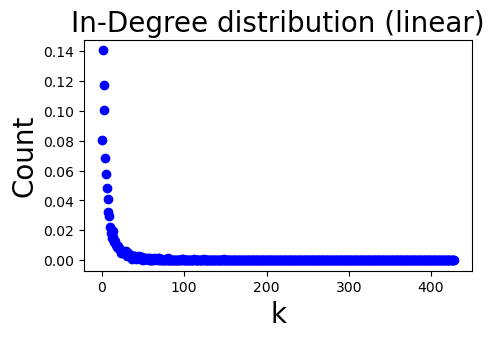

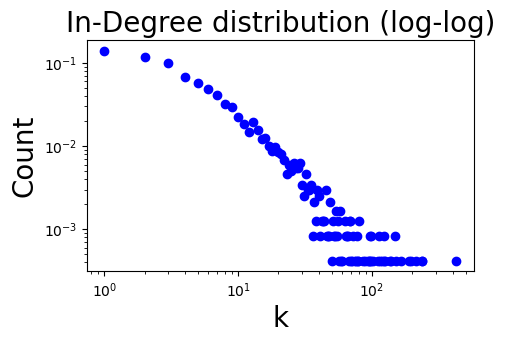

In [9]:
def degree_distribution(degs):
    maxdeg = degs[0]
    mindeg = degs[-1]
    
    kvalues= np.arange(0,maxdeg+1) # possible values of k
    count = np.zeros(maxdeg+1) # P(k)
    for k in degs:
        count[k] = count[k] + 1
    count = count/sum(count) # the sum of the elements of count(Pk) must to be equal to one
    return kvalues,count

all_indegree = sorted(G.in_degree, key=lambda x: x[1], reverse=True)
all_indegree_nums = list(list(zip(*all_indegree))[1])
ks_in, count_in = degree_distribution(all_indegree_nums)

plt.figure(figsize=(5,3))
plt.plot(ks_in,count_in,'bo')
plt.xlabel("k", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.title("In-Degree distribution (linear)", fontsize=20)

plt.figure(figsize=(5,3))
plt.loglog(ks_in,count_in,'bo')
plt.xlabel("k", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.title("In-Degree distribution (log-log)", fontsize=20)

**Out-degree**

Text(0.5, 1.0, 'Out-Degree distribution (log-log)')

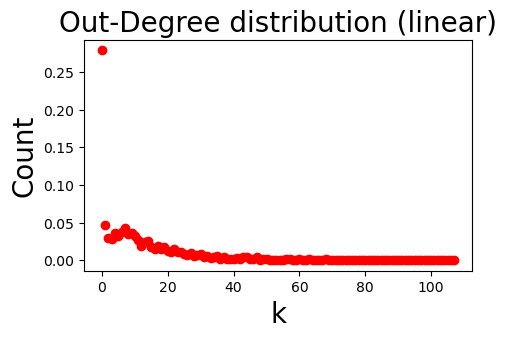

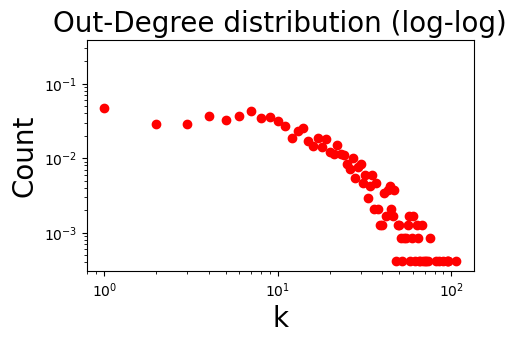

In [10]:
all_outdegree = sorted(G.out_degree, key=lambda x: x[1], reverse=True)
all_outdegree_nums = list(list(zip(*all_outdegree))[1])
ks_out, count_out = degree_distribution(all_outdegree_nums)

plt.figure(figsize=(5,3))
plt.plot(ks_out,count_out,'ro')
plt.xlabel("k", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.title("Out-Degree distribution (linear)", fontsize=20)

plt.figure(figsize=(5,3))
plt.loglog(ks_out,count_out,'ro')
plt.xlabel("k", fontsize=20)
plt.ylabel("Count", fontsize=20)
plt.title("Out-Degree distribution (log-log)", fontsize=20)

* Estimate the slope of the incoming degree distribtion as described in Lecture 5.

In [11]:
alpha_in = powerlaw.Fit(all_indegree_nums).alpha
print("Estimate the slope of the incoming degree distribtion: ", alpha_in)

Calculating best minimal value for power law fit
xmin progress: 00%
xmin progress: 00%
xmin progress: 01%
xmin progress: 02%
xmin progress: 03%
xmin progress: 04%
xmin progress: 05%
xmin progress: 06%
xmin progress: 07%
xmin progress: 08%
xmin progress: 09%
xmin progress: 10%
xmin progress: 11%
xmin progress: 12%
xmin progress: 13%
xmin progress: 14%
xmin progress: 15%
xmin progress: 16%
xmin progress: 17%
xmin progress: 18%
xmin progress: 19%
xmin progress: 20%
xmin progress: 21%
xmin progress: 22%
xmin progress: 23%
xmin progress: 24%
xmin progress: 25%
xmin progress: 26%
xmin progress: 27%
xmin progress: 28%
xmin progress: 29%
xmin progress: 30%
xmin progress: 31%
xmin progress: 32%
xmin progress: 33%
xmin progress: 34%
xmin progress: 35%
xmin progress: 36%
xmin progress: 37%
xmin progress: 38%
xmin progress: 39%
xmin progress: 40%
xmin progress: 41%
xmin progress: 42%
xmin progress: 43%
xmin progress: 44%
xmin progress: 45%
xmin progress: 46%
xmin progress: 47%
xmin progress: 48%
x

Values less than or equal to 0 in data. Throwing out 0 or negative values


* Plot the network using the Force Atlas algorithm as described in Lecture 5.

100%|███████████████████████████████████████| 2000/2000 [01:14<00:00, 26.72it/s]


BarnesHut Approximation  took  35.56  seconds
Repulsion forces  took  37.04  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.12  seconds
AdjustSpeedAndApplyForces step  took  1.09  seconds


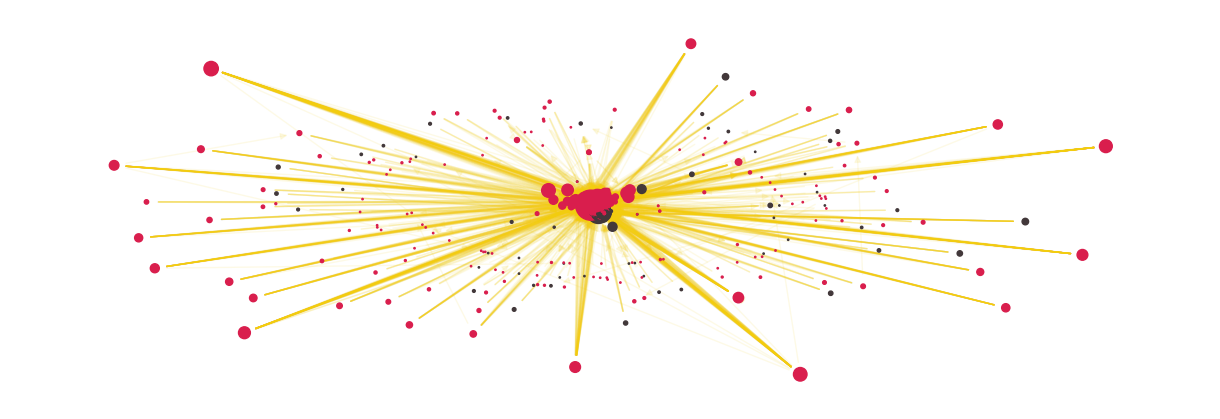

In [12]:
plt.figure(figsize=(12, 4))

color_state_map = {"DC": "#42383a", "Marvel": "#d91e4d"}  #DC: Green and Marvel: Blue

degrees = nx.degree(G)

pos = nx.draw_kamada_kawai(G)

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2.0,
                        strongGravityMode=True,
                        gravity=5.0,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=pos, iterations=2000)
nx.draw_networkx_nodes(G, positions, 
                       node_size=[degrees[v] for v in G.nodes()], 
                       label=False, 
                       node_color=[color_state_map[uni_node[1]['universe']] for uni_node in G.nodes(data=True)], 
                       alpha=1.0)
nx.draw_networkx_edges(G, positions, edge_color="#f2cc0f", alpha=0.1)
plt.axis('off')
plt.show()

# Communities

**Identify the communities in one or both of the superhero universes (DC/Marvel) as described in Week 7.**

In [13]:
undi_G = G.to_undirected()
print(undi_G)

Graph with 2376 nodes and 21777 edges


From week_7, we have to change it to be an undirected graph, so here, we changed the network to be an undirected graph that we could deal with later.

In [14]:
marvel_calist = [x for x, y in undi_G.nodes(data=True) if y["universe"] == "Marvel"]
marvel_G = undi_G.subgraph(marvel_calist).copy()
print(marvel_G)

Graph with 1829 nodes and 17191 edges


Here, we chose the Marvel universe(network) to continue the rest of the actions, which is more communities than the DC universe. 

In [16]:
marvel_G.remove_nodes_from(list(nx.isolates(marvel_G))) 
print(marvel_G)

Graph with 1820 nodes and 17191 edges


Remove the nodes that are isolated, making the graph to be focused on the critical part. Also, make the pattern of visualization clear.

In [22]:
#first compute the best partition
partition = community.best_partition(marvel_G)
print(list(partition.items())[:10])

[('Spider-Man', 0), ('Daredevil_(Marvel_Comics_character)', 0), ('Galactus', 1), ('Toro_(comics)', 1), ('Human_Torch_(android)', 1), ('Leonardo_da_Vinci', 2), ('Hera', 3), ('Hephaestus', 3), ('Ghoul', 4), ('Blackwing_(character)', 1)]


In each tuple, the name is the Marvel character, and the number is what community it belongs to.

In [47]:
partition_count = Counter(partition.values())
partition_count = {k: v for k, v in sorted(partition_count.items(), key=lambda item: item[1], reverse=True)}
partition_count

{1: 419,
 4: 412,
 0: 408,
 5: 194,
 8: 125,
 10: 82,
 6: 77,
 7: 43,
 2: 27,
 11: 13,
 3: 9,
 13: 7,
 12: 2,
 9: 2}

We could see through this cell to know how many nodes in different communities in a values decending sequence.

**Visualize the communities by coloring the graph's nodes according to community affiliation - also as described in Week 7.**

100%|███████████████████████████████████████| 2000/2000 [00:38<00:00, 51.83it/s]


BarnesHut Approximation  took  10.73  seconds
Repulsion forces  took  26.05  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.22  seconds
AdjustSpeedAndApplyForces step  took  0.83  seconds


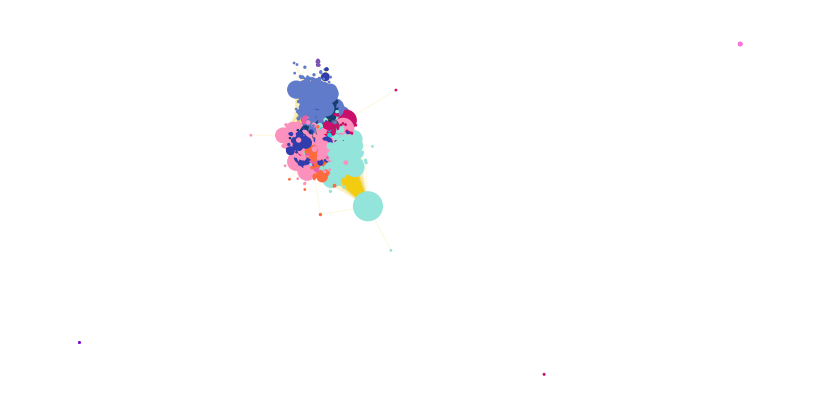

In [72]:
plt.figure(figsize=(8, 4))

degrees = nx.degree(marvel_G)

pos = nx.draw_kamada_kawai(marvel_G)

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        strongGravityMode=True,
                        gravity=7.0,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(marvel_G, pos=pos, iterations=2000)

colors = []
for i in range(len(partition_count)):
    colors.append("#" "%06x" % random.randint(0, 0xFFFFFF))

    
nx.draw_networkx_nodes(marvel_G, positions, 
                       node_size=[degrees[v] for v in marvel_G.nodes()], 
                       label=False, 
                       node_color=[colors[x] for x in partition.values()], 
                       alpha=1.0)

nx.draw_networkx_edges(marvel_G, positions, edge_color="#f2cc0f", alpha=0.1)
plt.axis('off')
plt.show()

**Write a paragraph about your work to identify the communities. The paragraph should include**

* Information about the algorithm you used to find communities.
* The value of modularity for your network.
* The number of communities and their sizes (in terms of number of nodes).

***Louvain Algorithm***, an algorithm for community finding, it will randomly order all nodes in the network in Modularity Optimization. Then, one by one, it will remove and insert each node in a different community $C$ until no significant increase in modularity (input parameter) is verified.

Through this algorithm, we could find the maximum value of modularity for partitioning the graph into various communities, which means the best modularity. 

In [49]:
L = len(marvel_G.edges)
Lc = []
kc = []
Nc = []

# Nc, Lc, kc
for i in range(len(partition_count)):
    marvel_clist = [x for x, y in partition.items() if y == i]
    marvel_Gc = marvel_G.subgraph(marvel_clist).copy()
    Lc.append(len(marvel_Gc.edges))
    Nc.append(len(marvel_Gc.nodes))

    Gc_degree = list(marvel_Gc.degree)
    v = [c for t,c in Gc_degree]
    kc.append(sum(v))

#Calculate Modularity
M = 0
for j in range(len(partition_count)):
    M += Lc[j]/L - (kc[j]/(2*L))**2

print(M)

0.5310471172684216


We could see the value of modularity in our communities is high, around 0.53, and also it is the best modularity for the Marvel graph. 

Besides the value of modularity, moreover, we could see how many communities and the size of the different communities.

In [50]:
print("The number of communities: ", len(partition_count))
#print("\n")

for i in range(len(partition_count)):
    print("The number of nodes in community {}: {}" .format(i+1, Nc[i]))

The number of communities:  14
The number of nodes in community 1: 408
The number of nodes in community 2: 419
The number of nodes in community 3: 27
The number of nodes in community 4: 9
The number of nodes in community 5: 412
The number of nodes in community 6: 194
The number of nodes in community 7: 77
The number of nodes in community 8: 43
The number of nodes in community 9: 125
The number of nodes in community 10: 2
The number of nodes in community 11: 82
The number of nodes in community 12: 13
The number of nodes in community 13: 2
The number of nodes in community 14: 7


We could see the communities in the Marvel network. 

**For the 10 largest communities, process the text in order to create a TF-IDF vector for each community. Explain in your own words how TF-IDF works.**

In [51]:
partition_count_ten = list(partition_count.keys())[:10]
partition_count_ten

[1, 4, 0, 5, 8, 10, 6, 7, 2, 11]

We chose ten biger communities in Marvel graph.

In [52]:
#TF
wiki_path = "https://en.wikipedia.org/wiki/"
def wiki_content(ca):
    try:
        source = urlopen(wiki_path + ca).read()
        soup = BeautifulSoup(source, "html.parser")
        #print(set([text.parent.name for text in soup.find_all(text=True)])) #print everything configuration in the "soup"

        # Extract the plain text content from paragraphs
        text = ''
        for paragraph in soup.find_all('p'):
            text += paragraph.text

        #Drop footnote and "\n" in the paragraph
        text = re.sub(r'\[.*?\]+', '', text)
        text = text.replace('\n', '')
        text = text.translate(str.maketrans('', '', string.punctuation))
        text = text + " "
        return text
    except:
        text = ""
        return text
    
def Make_TF(com):
    com_lower = [w.lower() for w in com]
    com_lower = ''.join(com_lower)
    com_lower = com_lower.split()
    filtered_words = [word for word in com_lower if word not in stopwords.words('english')]

    TF = Counter(filtered_words)
    TF = {k: v/len(filtered_words) for k, v in sorted(dict(TF).items(), key=lambda item: item[1], reverse=True)}
    TF = list(TF.items())
    return TF, filtered_words
    
#Make the community lists
community_1 = ""
community_2 = ""
community_3 = ""
community_4 = ""
community_5 = ""
community_6 = ""
community_7 = ""
community_8 = ""
community_9 = ""
community_10 = ""
  
for key, value in partition.items():
    if value == partition_count_ten[0]:
        community_1 += wiki_content(key)
    elif value == partition_count_ten[1]:
        community_2 += wiki_content(key)
    elif value == partition_count_ten[2]:
        community_3 += wiki_content(key)
    elif value == partition_count_ten[3]:
        community_4 += wiki_content(key)
    elif value == partition_count_ten[4]:
        community_5 += wiki_content(key)
    elif value == partition_count_ten[5]:
        community_6 += wiki_content(key)
    elif value == partition_count_ten[6]:
        community_7 += wiki_content(key)
    elif value == partition_count_ten[7]:
        community_8 += wiki_content(key)
    elif value == partition_count_ten[8]:
        community_9 += wiki_content(key)
    elif value == partition_count_ten[9]:
        community_10 += wiki_content(key)
    else:
        pass


TF_1, c1 = Make_TF(community_1)
TF_2, c2 = Make_TF(community_2)
TF_3, c3 = Make_TF(community_3)
TF_4, c4 = Make_TF(community_4)
TF_5, c5 = Make_TF(community_5)
TF_6, c6 = Make_TF(community_6)
TF_7, c7 = Make_TF(community_7)
TF_8, c8 = Make_TF(community_8)
TF_9, c9 = Make_TF(community_9)
TF_10, c10 = Make_TF(community_10)

In [53]:
#IDF
N = len(partition_count_ten)

def idf(count):
    idf = math.log(N/count, 10)
    return idf

words_in_doc1 = list(set(c1))
words_in_doc2 = list(set(c2))
words_in_doc3 = list(set(c3))
words_in_doc4 = list(set(c4))
words_in_doc5 = list(set(c5))
words_in_doc6 = list(set(c6))
words_in_doc7 = list(set(c7))
words_in_doc8 = list(set(c8))
words_in_doc9 = list(set(c9))
words_in_doc10 = list(set(c10))

all_text = words_in_doc1 + words_in_doc2 + words_in_doc3 + words_in_doc4 + words_in_doc5 + words_in_doc6 + words_in_doc7 + words_in_doc8 + words_in_doc9 + words_in_doc10

cnt = Counter()

for text in all_text:
    cnt[text] += 1
    
cnt = dict(cnt)

IDF = {}

for key, value in cnt.items():
    IDF[key] = idf(value)

In [54]:
TF_1 = dict(TF_1)
TF_2 = dict(TF_2)
TF_3 = dict(TF_3)
TF_4 = dict(TF_4)
TF_5 = dict(TF_5)
TF_6 = dict(TF_6)
TF_7 = dict(TF_7)
TF_8 = dict(TF_8)
TF_9 = dict(TF_9)
TF_10 = dict(TF_10)

In [55]:
tf_idf_1 = {}
tf_idf_2 = {}
tf_idf_3 = {}
tf_idf_4 = {}
tf_idf_5 = {}
tf_idf_6 = {}
tf_idf_7 = {}
tf_idf_8 = {}
tf_idf_9 = {}
tf_idf_10 = {}
tf_idf = {}

def TF_IDF(tf):
    for key in IDF.keys():
        try:
            tf_idf[key] = tf[key]*IDF[key]
        except:
            pass
        
    return tf_idf

tf_idf_1 = TF_IDF(TF_1)
tf_idf_2 = TF_IDF(TF_2)
tf_idf_3 = TF_IDF(TF_3)
tf_idf_4 = TF_IDF(TF_4)
tf_idf_5 = TF_IDF(TF_5)
tf_idf_6 = TF_IDF(TF_6)
tf_idf_7 = TF_IDF(TF_7)
tf_idf_8 = TF_IDF(TF_8)
tf_idf_9 = TF_IDF(TF_9)
tf_idf_10 = TF_IDF(TF_10)

In [56]:
print("The TF-IDF value of three words from the community one: ",list(tf_idf_1.items())[:3])
print("The TF-IDF value of three words from the community two: ", *list(tf_idf_2.items())[:3])
print("The TF-IDF value of three words from the community three: ", *list(tf_idf_3.items())[:3])
print("The TF-IDF value of three words from the community four: ", *list(tf_idf_4.items())[:3])
print("The TF-IDF value of three words from the community five: ", *list(tf_idf_5.items())[:3])
print("The TF-IDF value of three words from the community six: ", *list(tf_idf_6.items())[:3])
print("The TF-IDF value of three words from the community seven: ", *list(tf_idf_7.items())[:3])
print("The TF-IDF value of three words from the community eight: ", *list(tf_idf_8.items())[:3])
print("The TF-IDF value of three words from the community nine: ", *list(tf_idf_9.items())[:3])
print("The TF-IDF value of three words from the community ten: ", *list(tf_idf_10.items())[:3])

The TF-IDF value of three words from the community one:  [('underworldyears', 3.353700234053091e-06), ('ridged', 1.010998522253074e-06), ('greatgrandfather', 2.831011968664301e-06)]
The TF-IDF value of three words from the community two:  ('underworldyears', 3.353700234053091e-06) ('ridged', 1.010998522253074e-06) ('greatgrandfather', 2.831011968664301e-06)
The TF-IDF value of three words from the community three:  ('underworldyears', 3.353700234053091e-06) ('ridged', 1.010998522253074e-06) ('greatgrandfather', 2.831011968664301e-06)
The TF-IDF value of three words from the community four:  ('underworldyears', 3.353700234053091e-06) ('ridged', 1.010998522253074e-06) ('greatgrandfather', 2.831011968664301e-06)
The TF-IDF value of three words from the community five:  ('underworldyears', 3.353700234053091e-06) ('ridged', 1.010998522253074e-06) ('greatgrandfather', 2.831011968664301e-06)
The TF-IDF value of three words from the community six:  ('underworldyears', 3.353700234053091e-06) ('

First, TF part to calculate how often a word appears in a document we use 
$$
TF = \frac{the \; number \; of \; this \; word \; in \; this \; document} {How \; many \; words \; in \; this \; document}
$$
And the IDF calculates the diversity of a word if it appears in those documents. 
$$
IDF = log( \frac{Numbers\;of\;documents}{How\;many\;documents\;that\;the\;word\;existance\;in\;it})
$$. It assumes that if a word shows up in different documents, it means that this word is not essential, unique, or doesn't fruitful information(ex. stop words).

**Then visualize the TF-IDF vectors using wordclouds (as described in Week 7).**

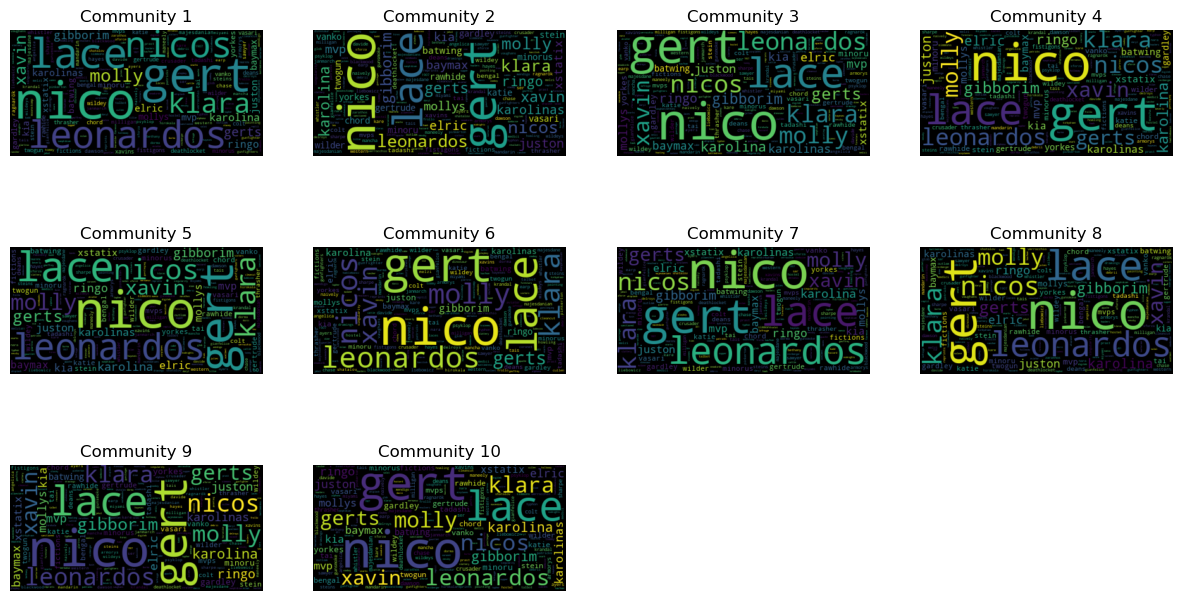

In [57]:
wordcloud_1 = WordCloud(max_font_size=80).fit_words(dict(tf_idf_1))
wordcloud_2 = WordCloud(max_font_size=80).fit_words(dict(tf_idf_2))
wordcloud_3 = WordCloud(max_font_size=80).fit_words(dict(tf_idf_3))
wordcloud_4 = WordCloud(max_font_size=80).fit_words(dict(tf_idf_4))
wordcloud_5 = WordCloud(max_font_size=80).fit_words(dict(tf_idf_5))
wordcloud_6 = WordCloud(max_font_size=80).fit_words(dict(tf_idf_6))
wordcloud_7 = WordCloud(max_font_size=80).fit_words(dict(tf_idf_7))
wordcloud_8 = WordCloud(max_font_size=80).fit_words(dict(tf_idf_8))
wordcloud_9 = WordCloud(max_font_size=80).fit_words(dict(tf_idf_9))
wordcloud_10 = WordCloud(max_font_size=80).fit_words(dict(tf_idf_10))

fig = plt.figure(figsize=(15, 8))

rows = 3
columns = 4

fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(wordcloud_1, interpolation="bilinear")
plt.axis('off')
plt.title("Community 1")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(wordcloud_2, interpolation="bilinear")
plt.axis('off')
plt.title("Community 2")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(wordcloud_3, interpolation="bilinear")
plt.axis('off')
plt.title("Community 3")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(wordcloud_4, interpolation="bilinear")
plt.axis('off')
plt.title("Community 4")

# Adds a subplot at the 5th position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(wordcloud_5, interpolation="bilinear")
plt.axis('off')
plt.title("Community 5")

# Adds a subplot at the 6th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(wordcloud_6, interpolation="bilinear")
plt.axis('off')
plt.title("Community 6")

# Adds a subplot at the 7th position
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(wordcloud_7, interpolation="bilinear")
plt.axis('off')
plt.title("Community 7")

# Adds a subplot at the 8th position
fig.add_subplot(rows, columns, 8)
  
# showing image
plt.imshow(wordcloud_8, interpolation="bilinear")
plt.axis('off')
plt.title("Community 8")

# Adds a subplot at the 9th position
fig.add_subplot(rows, columns, 9)
  
# showing image
plt.imshow(wordcloud_9, interpolation="bilinear")
plt.axis('off')
plt.title("Community 9")

# Adds a subplot at the 10th position
fig.add_subplot(rows, columns, 10)

# showing image
plt.imshow(wordcloud_10, interpolation="bilinear")
plt.axis('off')
plt.title("Community 10")

plt.show()

**Remember to comment on your word-clouds (e.g. in the figure captions): Do the wordclouds/TF-IDF lists enable you to understand the communities you have found (or is it just gibberish)? Justify your answer.**

**Ans.** <br>
Yes, but part of. The word cloud could let us see the most appearance but confused me with the TF-IDF. However, we could see from the different communities seem to have a very similar pattern. (“Ferro”, “sw6”, cale”, and “larfleeze” are obvious to see in each word cloud graph)

# Sentiment

First calculate the sentiment for all character pages. Calculate the mean value of the sentiment and the 10th and 90th percentile values for the sentiment. Then create a nice histogram displaying the distribution of sentiment values for all pages. Indicate the mean, etc on that histogram.

Now grab the good/bad character names ([from this file](https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2022/b1668fe5fbea0765ed6f9cf896bfaf208a13765b/files/wiki_meta_data.csv), see Week 8 for details) and calculate the same stats for only good/bad characters; also plot the histograms for the good/bad group and indicate the values of the mean, etc.

Finally use the label permutation test (see Week 5) to investigate the two hypotheses below
* H1: Good characters have a higher averge value for sentiment than a similarly sized set of randomly selected characters.
* H2: Bad characters have a lower average value for sentiment than a similarly sized set of randomly selected characters.

Write a short paragraph reflecting on your findings.

In [3]:
# get the data set from source
sen = 'https://journals.plos.org/plosone/article/file?type=supplementary&id=info:doi/10.1371/journal.pone.0026752.s001'
df_sen = pd.read_csv(sen, sep='\t', header = 2, 
                        usecols=['word', 'happiness_average'],
                        engine='python')

# Load a .csv file
# only the names and content are relevant
# please download the followed file into the same dir as this notebook
# https://dtudk-my.sharepoint.com/:x:/g/personal/s216410_dtu_dk/EdFxEEv95o1JoBtjlCrd55IBzhBeXX8HJa9AX_GSAkYUfg?e=4fVfOx
df_all      = pd.read_csv('df_base.csv', usecols= ['CharacterName', 'Content'], 
                            engine='python')
df_all.name = 'all comic Characters'

In [6]:
# clear up function for the content
# returns only tokens NOT in stopwords
def clear_up(content):
    try:
        tokenizer = nltk.RegexpTokenizer(r'\w+')
        wordsOnly = tokenizer.tokenize(content)
        tokens    = [w for w in wordsOnly if not w.lower() 
                        in stopwords.words('english')]
    except:
        tokens    = []
    return tokens

# shorten fucntion for lemamation
# can only handle one word at a time
# it will "purify" the tokens
lemmatizer = nltk.wordnet.WordNetLemmatizer()
lemma      = lemmatizer.lemmatize

In [7]:
# adding clear tokens
# this would take long
df_all['Tokens'] = df_all.Content.apply(clear_up) 
df_all['Tokens'] = df_all.Tokens.apply(lambda x: [lemma(i) for i in x])

In [8]:
# a dict for the sentiment score 
# every item in form of k,v: (word, score) 
senDict = {df_sen.at[i,'word']: float(df_sen.at[i,'happiness_average']) 
                for i in range(df_sen.shape[0])}

In [9]:
# keep only the tokens with score
# and have frequences of them
df_all['Tokens'] = df_all.Tokens.apply(lambda x: list(set(x) &
                                        set(senDict.keys())))
df_all['tf']     = df_all.Tokens.apply(FreqDist)

In [10]:
# mark the length of tf list for later calculation
# have sentiment set with both values and tokens
# recalculate the sentiment after total score is in
df_all['numOftf']   = df_all.tf.apply(len)
df_all['Sentiment'] = df_all.tf.apply(lambda x:
                                        {k: senDict[k]*v for k,v in x.items()})
df_all['totalSentiment'] = df_all.Sentiment.apply(lambda x: sum(x.values()))
df_all['Sentiment']      = df_all['totalSentiment']/df_all['numOftf']

In [11]:
def stats(df):
    df.mean      = np.mean(df['Sentiment'], axis=0)
    df.tenth     = np.nanpercentile(df['Sentiment'].values, 10)
    df.ninetieth = np.nanpercentile(df['Sentiment'].values, 90)
    print('Here are the sentiment stats of', df.name)
    print('The mean of the sentiment score is', df.mean)
    print('The 10th percentile of the sentiment score is', df.tenth)
    print('The 90th percentile of the sentiment score is', df.ninetieth)

stats(df_all)

Here are the sentiment stats of all comic Characters
The mean of the sentiment score is 5.444061852675934
The 10th percentile of the sentiment score is 5.304199944766639
The 90th percentile of the sentiment score is 5.595998774978946


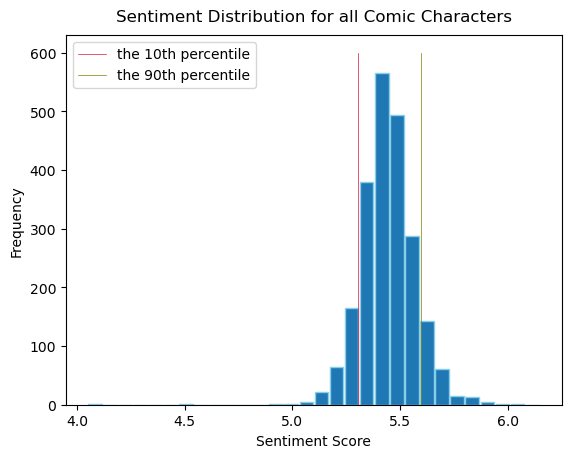

In [12]:
dist = dict(zip(list(df_all.CharacterName.values), list(df_all.Sentiment.values)))
v    = np.arange(min(df_all.Sentiment), max(df_all.Sentiment), step=.07)

# plotting
plt.hist(dist.values(), v, ec = 'skyblue', rwidth=.9)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.plot([df_all.tenth,df_all.tenth], [0,600], c='crimson', lw=.5, 
            label='the 10th percentile')
plt.plot([df_all.ninetieth,df_all.ninetieth], [0,600], c='olive',
            lw=.5, label='the 90th percentile')
plt.title('Sentiment Distribution for all Comic Characters', pad=10.0)
plt.legend(['the 10th percentile','the 90th percentile'], loc='upper left')
plt.show()

In [13]:
goodbad = 'https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2022/b1668fe5fbea0765ed6f9cf896bfaf208a13765b/files/wiki_meta_data.csv'

df_goodbad = pd.read_csv(goodbad, sep=',', 
                            usecols=['CharacterName','good','bad'],
                            engine='python')
df_goodbad = df_goodbad.merge(df_all, how='left', on='CharacterName')

In [14]:
# having two different df for good and bad section
df_good, df_good.name = df_goodbad[df_goodbad.good==1], 'the comic heroes' 
df_bad, df_bad.name   = df_goodbad[df_goodbad.bad==1], 'the comic villains'

In [15]:
# see the stats for good and bad characters
stats(df_good)
stats(df_bad)

Here are the sentiment stats of the comic heroes
The mean of the sentiment score is 5.478261004672789
The 10th percentile of the sentiment score is 5.369652856718145
The 90th percentile of the sentiment score is 5.597125991449207
Here are the sentiment stats of the comic villains
The mean of the sentiment score is 5.399515869431969
The 10th percentile of the sentiment score is 5.278878504672896
The 90th percentile of the sentiment score is 5.522750929368031


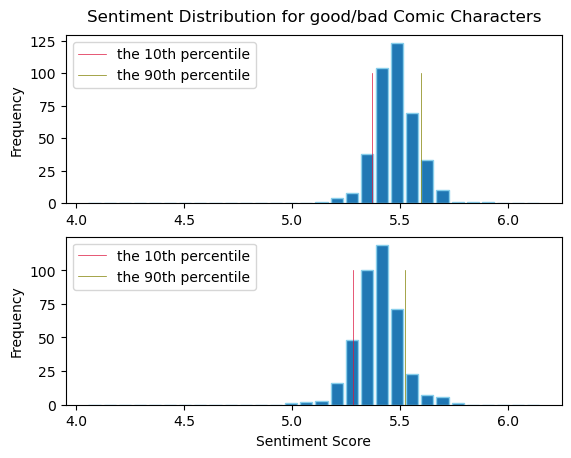

In [16]:
# plotting the distributions for both good and bad in the same plot
dist_g = dict(zip(list(df_good.CharacterName.values), list(df_good.Sentiment.values)))
v_g    = np.arange(min(df_good.Sentiment), max(df_good.Sentiment), step=0.08)
dist_b = dict(zip(list(df_bad.CharacterName.values), list(df_bad.Sentiment.values)))
v_b    = np.arange(min(df_bad.Sentiment), max(df_bad.Sentiment), step=0.08)

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.hist(dist_g.values(), v, ec = 'skyblue', rwidth=.8)
ax2.hist(dist_b.values(), v, ec = 'skyblue', rwidth=.8)
ax2.set_xlabel('Sentiment Score')
ax1.set_ylabel('Frequency')
ax2.set_ylabel('Frequency')
ax1.plot([df_good.tenth,df_good.tenth], [0,100], c='crimson', lw=.5, 
            label='the 10th percentile')
ax1.plot([df_good.ninetieth,df_good.ninetieth], [0,100], c='olive',
            lw=.5, label='the 90th percentile')
ax2.plot([df_bad.tenth,df_bad.tenth], [0,100], c='crimson', lw=.5, 
            label='the 10th percentile')
ax2.plot([df_bad.ninetieth,df_bad.ninetieth], [0,100], c='olive',lw=.5, 
            label='the 90th percentile')
ax1.set_title('Sentiment Distribution for good/bad Comic Characters', pad=10.0)
ax1.legend(['the 10th percentile','the 90th percentile'], loc='upper left')
ax2.legend(['the 10th percentile','the 90th percentile'], loc='upper left')
plt.show()

Ans: From the stats above, we can conclude that the good guys are above average sentimental and the bad guys are the opposite, but not a significant difference. As the locations of interval of the 10th and 90th percentile indicate, the interval from heroes starts at a smaller number whereas the villains' starts at a bigger one, and both last about the same length. Revisiting our hypotheses: 1) Good characters have a higher average value for sentiment than a similarly sized set of randomly selected characters; 2) Bad characters have a lower average value for sentiment than a similarly sized set of randomly selected characters. The data do not clearly suggest either of them.